In [8]:
# Python import
import collections
import numpy

# PlantGL geometric library
import openalea.plantgl.all as pgl

# Wheat simulation (already compliant for architectural query)
from alinea.adel.astk_interface import AdelWheat

# MTG selection
from alinea.alep.architecture import get_leaves

# Generic algorithm to disperse DispersalUnit on MTG
from alinea.alep.protocol import disperse

# Lesion 
from alinea.alep.fungus import Lesion, Fungus

# transport
from alinea.alep.models.dispersal.transport import SeptoriaRainDispersal

In [9]:
# sample weather data from astk
from openalea.deploy.shared_data import shared_data
import alinea.astk
from alinea.astk.Weather import Weather
meteo_path = shared_data(alinea.astk, 'meteo00-01.txt')
weather = Weather(meteo_path)
# retrieve weather data during a rain (hack, use rain event detection instead)
weather_data = weather.get_weather(weather.date_range_index('2000-12-01 15:00',by=3))

In [10]:
# utility to ompute lai on wheat mtg generated by adel
def adel_lai(adel, g):
    labels = g.property('label')
    areas = g.property('area')
    leaf_areas =[areas[k] for k,v in labels.items() if v.startswith('LeafElement')]
    return sum(leaf_areas) * adel.convUnit**2 / adel.domain_area


In [11]:
# utilities to place the source leaf
def is_iterable(obj):
    """ Test if object is iterable """
    return isinstance(obj, collections.Iterable)
    
def get_source_leaf_and_max_height(g, position='center', relative_height=2./3):
    """ Returns the vertex identifier and its height (z ccord).
    
    :Algorithm:
        Select all the leaves.
        Compute the bounding box of each leaf and its center (centroid).
        Compute the maximum height (z max) of all the centroids
        Then, compute the distance (norm) ???
    """
    tesselator = pgl.Tesselator()
    bbc = pgl.BBoxComputer(tesselator)
    leaves = get_leaves(g, label='LeafElement')
    centroids = g.property('centroid')
    geometries = g.property('geometry')
    targets = list(leaf for leaf in leaves if leaf in geometries.keys())
    for vid in targets:
        if is_iterable(geometries[vid]):
            bbc.process(pgl.Scene(geometries[vid]))
        else:
            bbc.process(pgl.Scene([pgl.Shape(geometries[vid])]))
        center = bbc.result.getCenter()
        centroids[vid] = center
    zmax = max(centroids.items(), key=lambda x:x[1][2])[1][2]
    distances = {vid:pgl.norm(centroids[vid]-(0,0,relative_height*zmax)) for vid in centroids}
    if position=='center':
        return min(distances.items(), key=lambda x:x[1])[0], zmax
    elif position=='border':
        return max(distances.items(), key=lambda x:x[1])[0], zmax

# Creation of a rain-responsive lesion
inspired from Rapilly and Jolivet model (1974)

In [12]:
# Create our own emitting lesion for this example
class RainSensitiveLesion(Lesion):
    """ A simple Lesion that simulate emission as in the Rapilly et al (1971) model
    """
    # proportionality betwwen rain intensity (mm.h-1) and total number of droplets produced during a rain event by a unit free water area
    pFA = 6.19e7
    # proportion of droplets that could not carry spores
    pEv = 0.36 
    
    def __init__(self, area=1e-4, mutable=False):
        super(RainSensitiveLesion, self).__init__()
        self.fungus_name = "rain_sensitive_fungus"
        self.area = area

    def emission(self, canopy_rain_intensity):
        """ spore emission
        
        args:
            canopy_rain_intensity: mean rain intensity within canopy (mm.h-1) 
        """
        return self.pFA * self.pEv * canopy_rain_intensity * self.area

# Create an emission model
this model simulates rain intensity decrease witinn the canopy using beer lambert equation

In [13]:
class RainEmission:
    """  Simple Beer lambert canopy based emission model:
        canopy_rain_intensity = rain_intensity * (1 - exp(-k * lai))
    """
    
    def __init__(self, k = 0.65):
        """ Initialize the model with fixed parameters.
        
        Parameters
        ----------
        domain_area: float
            Domain area of the canopy stand (m2)
        k: extinction coefficient
        """
        self.k = k
        
    def get_dispersal_units(self, g, rain_intensity, lai, **kwds):
        """ Compute emission of dispersal units by rain splash on wheat.
        
        Parameters
        ----------
        g: MTG
            MTG representing the canopy 
        rain_intensity
            rain intensity (mm.h-1) 
        lai: canopy leaf area index
                    
        Returns
        -------
        dispersal_units : dict([leaf_id, nb dispersal unit])
            Dispersal units emitted by leaf.
        """
        
        # Compute intercept with Beer Lambert
        canopy_rain_intensity = rain_intensity * (1 - numpy.exp(-self.k * lai))
        
        # Get lesions
        lesions = g.property('lesions')
        
        # Compute total sporulating area
        DU = {}
        for vid, l in lesions.items():
            for lesion in l:
                # Compute number of dispersal units emitted by lesion
                if vid not in DU:
                    DU[vid] = 0
                DU[vid] += lesion.emission(canopy_rain_intensity)
        return DU

#Simulation

In [14]:
# create wheat canopy 
adel= AdelWheat(nplants=3, nsect=7)
g = adel.setup_canopy(1500)



In [15]:
# inoculate one leaf
vid, hmax = get_source_leaf_and_max_height(g)
source_leaf = g.node(vid)
fungus = Fungus(Lesion=RainSensitiveLesion, parameters={"name":"rain_sensitive_fungus"})
source_lesion = fungus.lesion(area=1e-4)
source_leaf.lesions = [source_lesion]

<ipython-input-11-0e54d4aac118>:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  return isinstance(obj, collections.Iterable)


In [16]:
# Setup dispersal models + parameters for dispersion
emitter = RainEmission()
#rain 3d (slow)
transporter = SeptoriaRainDispersal()

# Simulate one dispersal event
lai = adel_lai(adel, g)
rain_intensity = weather_data.rain.mean()

g = disperse(g, emission_model=emitter, transport_model=transporter,lai=lai, rain_intensity=rain_intensity)

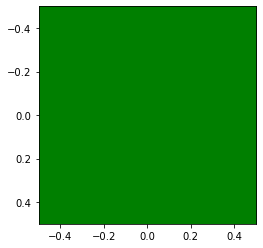

In [17]:
%gui qt
transporter.plot_distri_3d(g)